In [1]:
import warnings
warnings.filterwarnings("ignore") 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import date, datetime
import calendar

import geopandas
import shapely
import folium
from zipfile import ZipFile as zip
from shapely.geometry import Point, Polygon, LineString, MultiPoint, MultiLineString, MultiPolygon
from geojson import Point, Feature, FeatureCollection, dump
from folium.plugins import MarkerCluster

pd.pandas.set_option('display.max_columns', None)
%matplotlib inline

# Feature Engineering 

In [2]:
trip = pd.read_csv("trip_only.csv")
trip.head()

start_time             end_time tripduration  from_station_id  \
0  2019-01-01 00:04:37  2019-01-01 00:11:07        390.0              199   
1  2019-01-01 00:08:13  2019-01-01 00:15:34        441.0               44   
2  2019-01-01 00:13:23  2019-01-01 00:27:12        829.0               15   
3  2019-01-01 00:13:45  2019-01-01 00:43:28       1783.0              123   
4  2019-01-01 00:14:52  2019-01-01 00:20:56        364.0              173   

                     from_station_name  to_station_id  \
0               wabash ave & grand ave             84   
1               state st & randolph st            624   
2                 racine ave & 18th st            644   
3       california ave & milwaukee ave            176   
4  mies van der rohe way & chicago ave             35   

               to_station_name    usertype  gender  birthyear  
0    milwaukee ave & grand ave  Subscriber    Male     1989.0  
1  dearborn st & van buren st   Subscriber  Female     1990.0  
2   western ave & fillmore st   Subscriber  Female     1994.0  
3            clark st & elm st  Subscriber    Male     1993.0  
4      streeter dr & grand ave  Subscriber    Male     1994.0

In [3]:
trip.shape

(4090673, 10)

In [4]:
station = pd.read_csv("station_only.csv")
station.head()

id                    name   latitude  longitude  dpcapacity
0   1          special events        NaN        NaN        11.0
1   2     Buckingham Fountain  41.876393 -87.620328        27.0
2   3          Shedd Aquarium  41.867226 -87.615355        55.0
3   4          Burnham Harbor  41.856268 -87.613348        23.0
4   5  state st & harrison st  41.874053 -87.627716        23.0

In [5]:
station.shape

(619, 5)

In [6]:
weather = pd.read_csv("weather_only.csv")
weather.head()

Column1    date     time  start_hour  end_hour               tz  \
0        0  1/1/19  0:59:53           0         1  America/Chicago   
1        1  1/1/19  1:59:53           1         2  America/Chicago   
2        2  1/1/19  2:59:53           2         3  America/Chicago   
3        3  1/1/19  3:59:53           3         4  America/Chicago   
4        4  1/1/19  4:59:53           4         5  America/Chicago   

  obsTimeLocal        lat        lon  solarRadiationHigh  uvHigh  winddirAvg  \
0  1/1/19 0:59  41.883579 -87.634338                 0.0     0.0       156.0   
1  1/1/19 1:59  41.883579 -87.634338                 0.0     0.0       147.0   
2  1/1/19 2:59  41.883579 -87.634338                 0.0     0.0       134.0   
3  1/1/19 3:59  41.883579 -87.634338                 0.0     0.0       141.0   
4  1/1/19 4:59  41.883579 -87.634338                 0.0     0.0       187.0   

   humidityHigh  humidityLow  humidityAvg  qcStatus  tempHigh  tempLow  \
0          99.0         97.0         97.0       1.0       2.0      2.0   
1          97.0         95.0         96.0       1.0       2.0      2.0   
2          96.0         93.0         94.0       1.0       2.0      1.0   
3          97.0         93.0         94.0       1.0       1.0      1.0   
4          99.0         96.0         98.0       1.0       1.0      0.0   

   tempAvg  windspeedHigh  windspeedLow  windspeedAvg  windgustHigh  \
0      2.0            1.0             0           0.0           2.0   
1      2.0            2.0             0           0.0           4.0   
2      2.0            4.0             0           0.0           7.0   
3      1.0            3.0             0           0.0           5.0   
4      1.0            7.0             0           1.0           9.0   

   windgustLow  windgustAvg  dewptHigh  dewptLow  dewptAvg  windchillHigh  \
0            0          0.0        2.0       2.0       2.0            2.0   
1            0          0.0        2.0       1.0       1.0            2.0   
2            0          1.0        1.0       0.0       1.0            2.0   
3            0          1.0        1.0       0.0       0.0            1.0   
4            0          1.0        1.0       0.0       0.0            1.0   

   windchillLow  windchillAvg  heatindexHigh  heatindexLow  heatindexAvg  \
0           2.0           2.0            2.0           2.0           2.0   
1           2.0           2.0            2.0           2.0           2.0   
2           1.0           2.0            2.0           1.0           2.0   
3           1.0           1.0            1.0           1.0           1.0   
4          -2.0           1.0            1.0           0.0           1.0   

   pressureMax  pressureMin  pressureTrend  precipRate  precipTotal  
0      1014.22      1012.53           1.02         0.0          0.0  
1      1015.92      1013.88           1.70         0.0          0.0  
2      1017.27      1015.58           1.36         0.0          0.0  
3      1018.29      1017.27           1.02         0.0          0.0  
4      1019.30      1018.29           1.02         0.0          0.0

In [7]:
weather.shape

(8784, 39)

In [8]:
trip_station = trip.merge(station[["id", "latitude", "longitude", "dpcapacity"]].add_prefix("origin_"), how="left", left_on = "from_station_id", right_on = "origin_id")
trip_station = trip_station.merge(station[["id", "latitude", "longitude", "dpcapacity"]].add_prefix("destination_"), how="left", left_on = "to_station_id", right_on = "destination_id")
trip_station.drop(columns=["origin_id", "destination_id"], inplace=True)

In [9]:
trip_station.head()

start_time             end_time tripduration  from_station_id  \
0  2019-01-01 00:04:37  2019-01-01 00:11:07        390.0              199   
1  2019-01-01 00:08:13  2019-01-01 00:15:34        441.0               44   
2  2019-01-01 00:13:23  2019-01-01 00:27:12        829.0               15   
3  2019-01-01 00:13:45  2019-01-01 00:43:28       1783.0              123   
4  2019-01-01 00:14:52  2019-01-01 00:20:56        364.0              173   

                     from_station_name  to_station_id  \
0               wabash ave & grand ave             84   
1               state st & randolph st            624   
2                 racine ave & 18th st            644   
3       california ave & milwaukee ave            176   
4  mies van der rohe way & chicago ave             35   

               to_station_name    usertype  gender  birthyear  \
0    milwaukee ave & grand ave  Subscriber    Male     1989.0   
1  dearborn st & van buren st   Subscriber  Female     1990.0   
2   western ave & fillmore st   Subscriber  Female     1994.0   
3            clark st & elm st  Subscriber    Male     1993.0   
4      streeter dr & grand ave  Subscriber    Male     1994.0   

   origin_latitude  origin_longitude  origin_dpcapacity  destination_latitude  \
0        41.891466        -87.626761               31.0             41.891578   
1        41.884730        -87.627734               27.0             41.876268   
2        41.858166        -87.656495               15.0             41.868605   
3        41.922695        -87.697153               15.0             41.902973   
4        41.896910        -87.621743               15.0             41.892278   

   destination_longitude  destination_dpcapacity  
0             -87.648384                    19.0  
1             -87.629155                    16.0  
2             -87.686228                    15.0  
3             -87.631280                    27.0  
4             -87.612043                    47.0

In [10]:
trip_station.isnull().sum()

start_time                   0
end_time                     0
tripduration                 0
from_station_id              0
from_station_name            0
to_station_id                0
to_station_name              0
usertype                     0
gender                       0
birthyear                    0
origin_latitude           2230
origin_longitude          2230
origin_dpcapacity            0
destination_latitude      2697
destination_longitude     2697
destination_dpcapacity       0
dtype: int64

In [11]:
trip_station.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4090673 entries, 0 to 4090672
Data columns (total 16 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   start_time              object 
 1   end_time                object 
 2   tripduration            object 
 3   from_station_id         int64  
 4   from_station_name       object 
 5   to_station_id           int64  
 6   to_station_name         object 
 7   usertype                object 
 8   gender                  object 
 9   birthyear               float64
 10  origin_latitude         float64
 11  origin_longitude        float64
 12  origin_dpcapacity       float64
 13  destination_latitude    float64
 14  destination_longitude   float64
 15  destination_dpcapacity  float64
dtypes: float64(7), int64(2), object(7)
memory usage: 530.6+ MB


In [12]:
trip_station["start_datetime_floor"] =  pd.to_datetime(trip_station["start_time"]).dt.floor("H")

In [13]:
weather["datetime_floor"] =  pd.to_datetime(weather["obsTimeLocal"]).dt.floor("H")

In [14]:
weather.drop(columns=['Column1','start_hour','end_hour','tz','lat','lon',], inplace=True)

In [15]:
#Drop some of the column in weather dataset before merging later on, merge by date and time
trip_station_weather = trip_station.merge(weather, how="left", left_on="start_datetime_floor", right_on="datetime_floor")

In [16]:
trip_station_weather.head()

start_time             end_time tripduration  from_station_id  \
0  2019-01-01 00:04:37  2019-01-01 00:11:07        390.0              199   
1  2019-01-01 00:08:13  2019-01-01 00:15:34        441.0               44   
2  2019-01-01 00:13:23  2019-01-01 00:27:12        829.0               15   
3  2019-01-01 00:13:45  2019-01-01 00:43:28       1783.0              123   
4  2019-01-01 00:14:52  2019-01-01 00:20:56        364.0              173   

                     from_station_name  to_station_id  \
0               wabash ave & grand ave             84   
1               state st & randolph st            624   
2                 racine ave & 18th st            644   
3       california ave & milwaukee ave            176   
4  mies van der rohe way & chicago ave             35   

               to_station_name    usertype  gender  birthyear  \
0    milwaukee ave & grand ave  Subscriber    Male     1989.0   
1  dearborn st & van buren st   Subscriber  Female     1990.0   
2   western ave & fillmore st   Subscriber  Female     1994.0   
3            clark st & elm st  Subscriber    Male     1993.0   
4      streeter dr & grand ave  Subscriber    Male     1994.0   

   origin_latitude  origin_longitude  origin_dpcapacity  destination_latitude  \
0        41.891466        -87.626761               31.0             41.891578   
1        41.884730        -87.627734               27.0             41.876268   
2        41.858166        -87.656495               15.0             41.868605   
3        41.922695        -87.697153               15.0             41.902973   
4        41.896910        -87.621743               15.0             41.892278   

   destination_longitude  destination_dpcapacity start_datetime_floor    date  \
0             -87.648384                    19.0           2019-01-01  1/1/19   
1             -87.629155                    16.0           2019-01-01  1/1/19   
2             -87.686228                    15.0           2019-01-01  1/1/19   
3             -87.631280                    27.0           2019-01-01  1/1/19   
4             -87.612043                    47.0           2019-01-01  1/1/19   

      time obsTimeLocal  solarRadiationHigh  uvHigh  winddirAvg  humidityHigh  \
0  0:59:53  1/1/19 0:59                 0.0     0.0       156.0          99.0   
1  0:59:53  1/1/19 0:59                 0.0     0.0       156.0          99.0   
2  0:59:53  1/1/19 0:59                 0.0     0.0       156.0          99.0   
3  0:59:53  1/1/19 0:59                 0.0     0.0       156.0          99.0   
4  0:59:53  1/1/19 0:59                 0.0     0.0       156.0          99.0   

   humidityLow  humidityAvg  qcStatus  tempHigh  tempLow  tempAvg  \
0         97.0         97.0       1.0       2.0      2.0      2.0   
1         97.0         97.0       1.0       2.0      2.0      2.0   
2         97.0         97.0       1.0       2.0      2.0      2.0   
3         97.0         97.0       1.0       2.0      2.0      2.0   
4         97.0         97.0       1.0       2.0      2.0      2.0   

   windspeedHigh  windspeedLow  windspeedAvg  windgustHigh  windgustLow  \
0            1.0             0           0.0           2.0            0   
1            1.0             0           0.0           2.0            0   
2            1.0             0           0.0           2.0            0   
3            1.0             0           0.0           2.0            0   
4            1.0             0           0.0           2.0            0   

   windgustAvg  dewptHigh  dewptLow  dewptAvg  windchillHigh  windchillLow  \
0          0.0        2.0       2.0       2.0            2.0           2.0   
1          0.0        2.0       2.0       2.0            2.0           2.0   
2          0.0        2.0       2.0       2.0            2.0           2.0   
3          0.0        2.0       2.0       2.0            2.0           2.0   
4          0.0        2.0       2.0       2.0            2.0           2.0   

   windchillAvg  he

In [17]:
trip_station_weather.shape

(4090673, 51)

In [18]:
trip_station_weather.drop(columns = ['start_datetime_floor','date','time','obsTimeLocal','datetime_floor'], inplace=True)

In [19]:
#Converting start_time and end_time datatype from string object to datetime object
trip_station_weather["start_time"] = pd.to_datetime(trip_station_weather["start_time"])
trip_station_weather["end_time"] = pd.to_datetime(trip_station_weather["end_time"])

In [20]:
#Fixing regex issue in the tripduration column
trip_station_weather["tripduration"] = trip_station_weather["tripduration"].apply(str)
trip_station_weather["tripduration"] = trip_station_weather["tripduration"].apply(lambda x: x.replace(",",""))
trip_station_weather["tripduration"] = trip_station_weather["tripduration"].apply(float)

In [21]:
#Create a new column and populate with day of week from the datetime, where 0 denotes monday, ..., 6 denotes sunday
trip_station_weather.loc[:, 'day_of_week'] = trip_station_weather['start_time'].apply(lambda x: x.weekday())

In [22]:
#Create a new column and populate with 1 if day is a weekday and 0 if day is a weekend
trip_station_weather['is_weekday'] = trip_station_weather['day_of_week'].apply(lambda x: 1 if x<5 else 0)

In [23]:
#Create a new column and populate with hour of the day based on start_time
trip_station_weather['hour_of_day'] = trip_station_weather['start_time'].apply(lambda x: x.hour)

In [24]:
#Create a new column and populate with year, month, date data only, drop the time
trip_station_weather["y_m_d"] = trip_station_weather["start_time"].apply(lambda x: x.strftime('%Y-%m-%d'))

In [25]:
#Converting y_m_d datatype from string object to datetime object
trip_station_weather["y_m_d"] = pd.to_datetime(trip_station_weather["y_m_d"])

In [26]:
#Create a new column and populate with season of the year (i.e. 1 denotes winter, 2 denotes spring, 3 denotes summer, 4 denotes autumn)
Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
seasons = [(1, (date(Y,  1,  1),  date(Y,  3, 20))),
           (2, (date(Y,  3, 21),  date(Y,  6, 20))),
           (3, (date(Y,  6, 21),  date(Y,  9, 22))),
           (4, (date(Y,  9, 23),  date(Y, 12, 20))),
           (1, (date(Y, 12, 21),  date(Y, 12, 31)))]

def get_season(now):
    if isinstance(now, datetime):
        now = now.date()
    now = now.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= now <= end)

trip_station_weather['season'] = trip_station_weather['start_time'].apply(get_season)

In [27]:
#Create a new column and populate with rider age
trip_station_weather['rider_age'] = 2019 - trip_station_weather['birthyear']

In [28]:
#Add data on holiday
hol = pd.read_csv('holidays.csv')

In [29]:
#Converting Date datatype from string object to datetime object
hol["Date"] = pd.to_datetime(hol["Date"])

In [30]:
#Create 3 new columns and populate with year, month, and date
hol['Year_Date'] = hol.Date.dt.year
hol['Month_Date'] = hol.Date.dt.month
hol['Day_Date'] = hol.Date.dt.day

In [31]:
#Create a new column and populate with boolean condition on whether the day is weekend (1) or weekday (0)
hol['Weekend'] = np.where(hol.Date.dt.weekday > 4, 1, 0)
hol.reset_index(inplace=True)

In [32]:
for i in range(len(hol['Date'])):
    if hol['Weekend'][i] == 1:
        if hol['Holiday_Name'][i] == "Not Holiday":
            hol['Holiday_Name'][i] = 'Weekend'

            
hol.rename(columns={'Date': 'y_m_d'}, inplace=True)

In [33]:
hol.drop(columns=["index", 'Weekend'], axis=1, inplace=True)

In [34]:
#Merging the holiday dataframe back to the original trip_station_weather dataset using inner join
trip_station_weather = trip_station_weather.merge(hol, how='inner', on=['y_m_d'])

In [35]:
#Get unique holiday name
holiday_names = list(set(trip_station_weather['Holiday_Name']))
holiday_names

['Winter Vacation',
 "President's Day",
 'Memorial Day',
 'Summer Vacation',
 'Not Holiday',
 'Christmas',
 'Spring Break',
 'Weekend',
 'Birthday of Martin Luther King, Jr.',
 'Day after Thanksgiving Day',
 'Veterans Day',
 "New Year's Day",
 'Thanksgiving Day']

In [36]:
# convert holiday names to numeric where 0 denotes Not Holiday, 1 denotes Spring/Summer/Winter Break, 2 denotes Weekend, 3 denotes all-other-miscellaneous holiday
# create 2 new columns is_holiday to denote whether the particular day is a holiday, break_types to denote holiday names abovementioned.
holiday_names = list(set(trip_station_weather['Holiday_Name']))
values = [1 if hol != "Not Holiday" else 0 for hol in holiday_names]
holiday_names1 = list(set(trip_station_weather['Holiday_Name']))
values1 = []
for hol in holiday_names1:
    if hol == 'Not Holiday':
        values1.append(0)
    elif hol == 'Spring Break' or hol == 'Summer Vacation' or hol == 'Winter Vacation':
        values1.append(1)
    elif hol == 'Weekend':
        values1.append(2)
    else:
        values1.append(3)

trip_station_weather['is_holiday'] = trip_station_weather['Holiday_Name'].replace(to_replace=holiday_names, value=values)
trip_station_weather['break_types'] = trip_station_weather['Holiday_Name'].replace(to_replace=holiday_names1, value=values1)
trip_station_weather

start_time            end_time  tripduration  \
0       2019-01-01 00:04:37 2019-01-01 00:11:07         390.0   
1       2019-01-01 00:08:13 2019-01-01 00:15:34         441.0   
2       2019-01-01 00:13:23 2019-01-01 00:27:12         829.0   
3       2019-01-01 00:13:45 2019-01-01 00:43:28        1783.0   
4       2019-01-01 00:14:52 2019-01-01 00:20:56         364.0   
...                     ...                 ...           ...   
4090668 2019-12-31 23:56:13 2020-01-01 00:15:45        1172.0   
4090669 2019-12-31 23:56:34 2020-01-01 00:22:08        1533.0   
4090670 2019-12-31 23:57:05 2020-01-01 00:05:46         520.0   
4090671 2019-12-31 23:57:11 2020-01-01 00:05:45         514.0   
4090672 2019-12-31 23:57:17 2019-12-31 23:59:18         120.0   

         from_station_id                    from_station_name  to_station_id  \
0                    199               wabash ave & grand ave             84   
1                     44               state st & randolph st            624   
2                     15                 racine ave & 18th st            644   
3                    123       california ave & milwaukee ave            176   
4                    173  mies van der rohe way & chicago ave             35   
...                  ...                                  ...            ...   
4090668              112               green st & randolph st            225   
4090669               90                      millennium park             90   
4090670              623                michigan ave & 8th st             52   
4090671              623                michigan ave & 8th st             52   
4090672              256               broadway & sheridan rd            240   

                      to_station_name    usertype  gender  birthyear  \
0           milwaukee ave & grand ave  Subscriber    Male     1989.0   
1         dearborn st & van buren st   Subscriber  Female     1990.0   
2          western ave & fillmore st   Subscriber  Female     1994.0   
3                   clark st & elm st  Subscriber    Male     1993.0   
4             streeter dr & grand ave  Subscriber    Male     1994.0   
...                               ...         ...     ...        ...   
4090668      halsted st & dickens ave  Subscriber    Male     1981.0   
4090669               millennium park  Subscriber    Male     1992.0   
4090670        michigan ave & lake st  Subscriber    Male     1967.0   
4090671        michigan ave & lake st  Subscriber  Female     1970.0   
4090672  sheridan rd & irving park rd  Subscriber    Male     1982.0   

         origin_latitude  origin_longitude  origin_dpcapacity  \
0              41.891466        -87.626761               31.0   
1              41.884730        -87.627734               27.0   
2              41.858166        -87.656495               15.0   
3              41.922695        -87.697153               15.0   
4              41.896910        -87.621743               15.0   
...                  ...               ...                ...   
4090668        41.883668        -87.648670               15.0   
4090669        41.881032        -87.624084               47.0   
4090670        41.872773        -87.623981               31.0   
4090671        41.872773        -87.623981               31.0   
4090672        41.952833        -87.649993               15.0   

         destination_latitude  destination_longitude  destination_dpcapacity  \
0                   41.891578             -87.648384                    19.0   
1                   41.876268             -87.629155                    16.0   
2                   41.868605             -87.686228                    15.0   
3                   41.902973             -87.631280                    27.0   
4                   41.892278             -87.612043                    47.0   
...                       ...                    ...                     ...   
4090668             41.919936             -87.648830                 

In [37]:
#Exporting trip_weather_station to csv (DON'T UNCOMMENT)
#trip_station_weather.to_csv("trip_weather_station.csv", index=False)

In [38]:
# #groupby day and time for predictive purposes (DON'T UNCOMMENT)
# daily = trip_station_weather.groupby(["y_m_d", "hour_of_day"]).agg({"tripduration": "mean",
#                                                     "solarRadiationHigh": "max",
#                                                     "uvHigh": "max",
#                                                     "winddirAvg": "mean",
#                                                     "humidityHigh": "max",
#                                                     "humidityLow": "min",
#                                                     "humidityAvg": "mean",
#                                                     "tempHigh": "max",
#                                                     "tempLow": "min",
#                                                     "tempAvg": "mean",
#                                                     "windspeedHigh": "max",
#                                                     "windspeedLow": "min",
#                                                     "windspeedAvg": "mean",
#                                                     "windgustHigh": "max",
#                                                     "windgustLow": "min",
#                                                     "windgustAvg": "mean",
#                                                     "dewptHigh": "max",
#                                                     "dewptLow": "min",
#                                                     "dewptAvg": "mean",
#                                                     "windchillHigh": "max",
#                                                     "windchillLow": "min",
#                                                     "windchillAvg": "mean",
#                                                     "heatindexHigh": "max",
#                                                     "heatindexLow": "min",
#                                                     "heatindexAvg": "mean",
#                                                     "pressureMax": "max",
#                                                     "pressureMin": "min",
#                                                     "pressureTrend": "mean",
#                                                     "precipRate": "mean",
#                                                     "precipTotal": "sum",
#                                                     "Year_Date": "mean",
#                                                     "Month_Date": "mean",
#                                                     "Day_Date": "mean",
#                                                     "is_holiday": "mean",
#                                                     "break_types": "mean",
#                                                     "start_time": "count" # need rename later    
#                                                     })
# daily = daily.reset_index()
# daily

# daily = daily.rename({"start_time": "Demand"}, axis=1)

# #Exporting daily to csv for predictive purpose
# #daily.to_csv("aggregated_hourly_data.csv", index=False)

In [39]:
# #groupby day and time for predictive purposes (DON'T UNCOMMENT)
# daily = trip_station_weather.groupby(["y_m_d"]).agg({"tripduration": "mean",
#                                                     "solarRadiationHigh": "max",
#                                                     "uvHigh": "max",
#                                                     "winddirAvg": "mean",
#                                                     "humidityHigh": "max",
#                                                     "humidityLow": "min",
#                                                     "humidityAvg": "mean",
#                                                     "tempHigh": "max",
#                                                     "tempLow": "min",
#                                                     "tempAvg": "mean",
#                                                     "windspeedHigh": "max",
#                                                     "windspeedLow": "min",
#                                                     "windspeedAvg": "mean",
#                                                     "windgustHigh": "max",
#                                                     "windgustLow": "min",
#                                                     "windgustAvg": "mean",
#                                                     "dewptHigh": "max",
#                                                     "dewptLow": "min",
#                                                     "dewptAvg": "mean",
#                                                     "windchillHigh": "max",
#                                                     "windchillLow": "min",
#                                                     "windchillAvg": "mean",
#                                                     "heatindexHigh": "max",
#                                                     "heatindexLow": "min",
#                                                     "heatindexAvg": "mean",
#                                                     "pressureMax": "max",
#                                                     "pressureMin": "min",
#                                                     "pressureTrend": "mean",
#                                                     "precipRate": "mean",
#                                                     "precipTotal": "sum",
#                                                     "Year_Date": "mean",
#                                                     "Month_Date": "mean",
#                                                     "Day_Date": "mean",
#                                                     "is_holiday": "mean",
#                                                     "break_types": "mean",
#                                                     "start_time": "count" # need rename later    
#                                                     })
# daily = daily.reset_index()
# daily

# daily = daily.rename({"start_time": "Demand"}, axis=1)

# #Exporting daily to csv for predictive purpose
# daily.to_csv("aggregated_daily_data.csv", index=False)

# Data Visualisation 

In [40]:
df = trip_station_weather

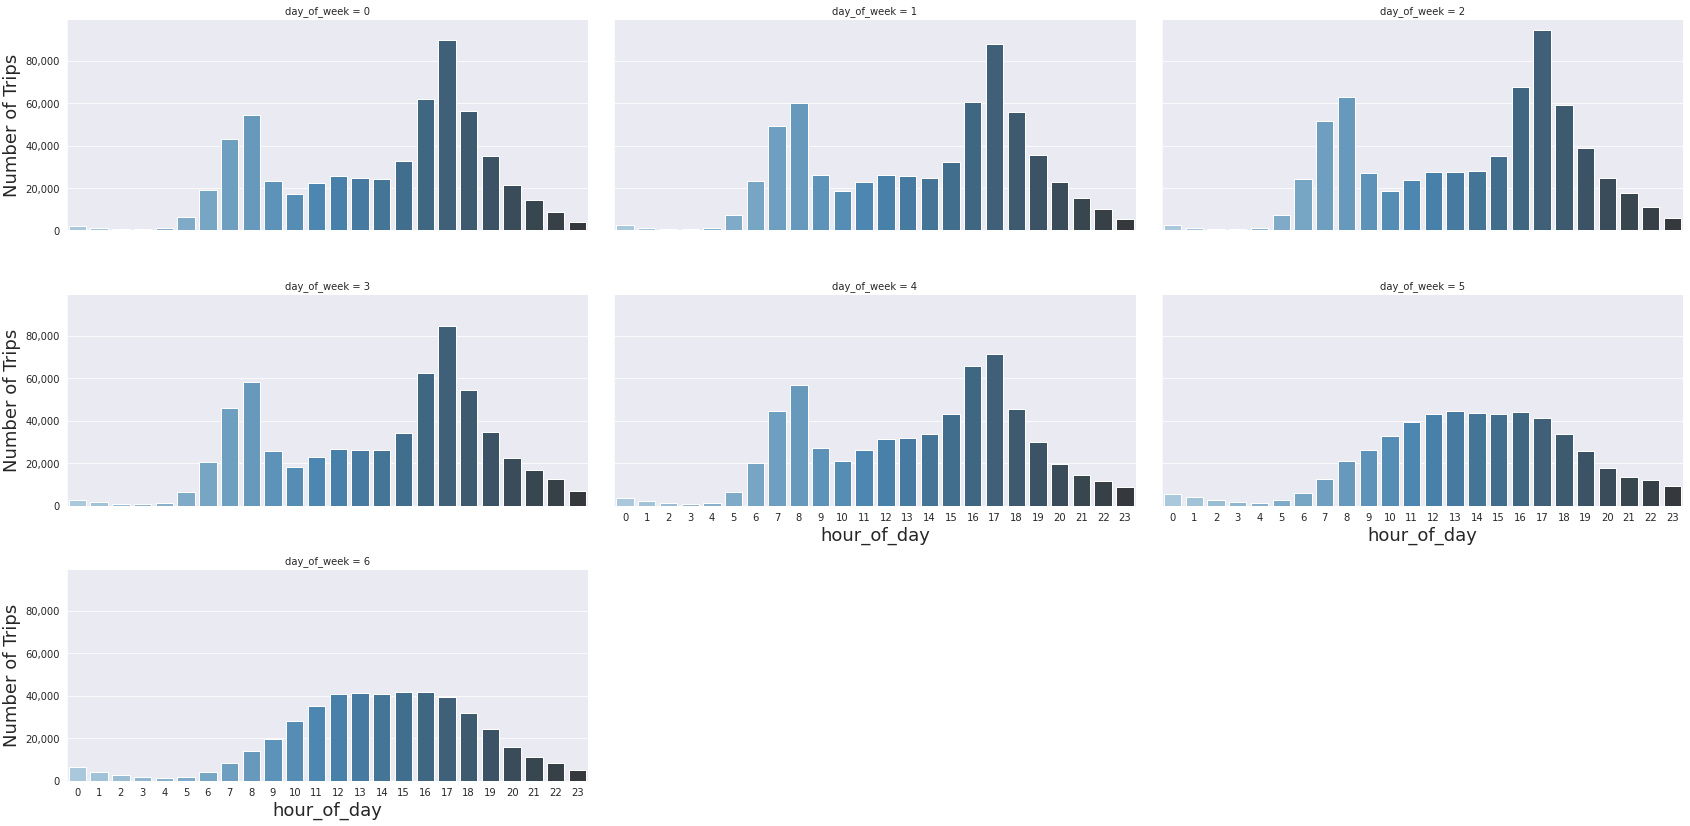

In [41]:
sns.set_style("darkgrid")

day_hour_trip = df.groupby(['day_of_week', 'hour_of_day']).start_time.count().reset_index()
day_hour_trip.rename(columns = {'start_time':'Number of Trips'}, inplace = True)

sea = sns.FacetGrid(day_hour_trip, col = "day_of_week",
                    height = 4, aspect = 2, col_wrap=3)

sns.set(font_scale=2)
sea.set_xlabels(fontsize=18)
sea.set_ylabels(fontsize=18)
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter("{x:,.0f}"))
sea.map(sns.barplot, "hour_of_day", "Number of Trips", palette='Blues_d')
sns.set()
sns.reset_defaults()

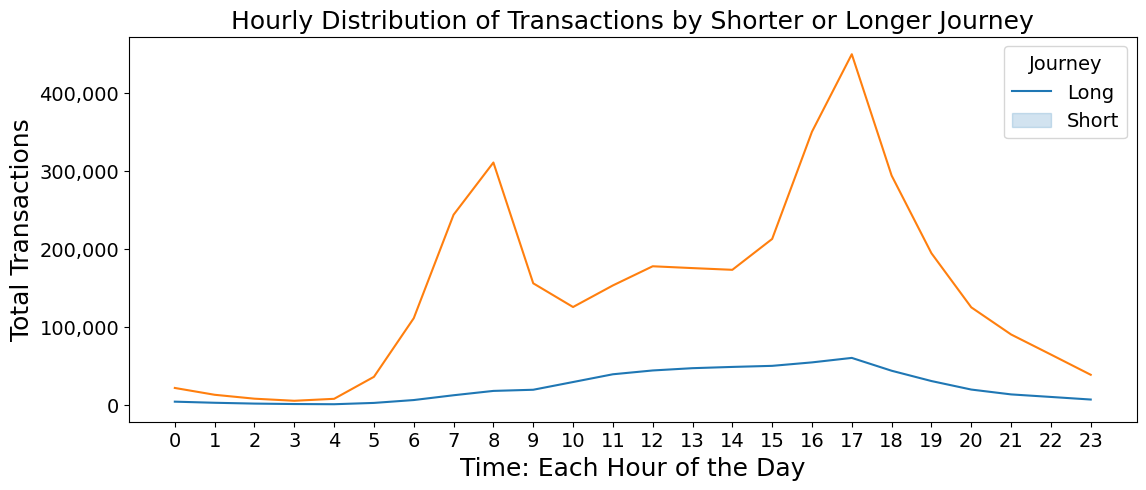

In [42]:
#Create a new column and populate with boolean values, 0 denotes long journey and 1 denotes long journey
df['is_short'] = 0
df.loc[df['tripduration']<1800, 'is_short'] = 1

Short_trip = df.groupby(['is_short','hour_of_day'],as_index=False)['gender'].count() \
                                            .rename(columns={'gender': 'total'}) 
sns.reset_defaults()
#Plot 
plt.figure(figsize=(13,5))
sns.lineplot(data=Short_trip, x='hour_of_day', y='total', hue='is_short').set_xticks(range(0,24))


import matplotlib as mpl
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter("{x:,.0f}"))

plt.xlabel('Time: Each Hour of the Day', fontsize=18)
plt.ylabel('Total Transactions', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Hourly Distribution of Transactions by Shorter or Longer Journey", fontsize=18)
plt.legend(["Long", "Short"], title="Journey", title_fontsize = 14, fontsize=14)

plt.show()

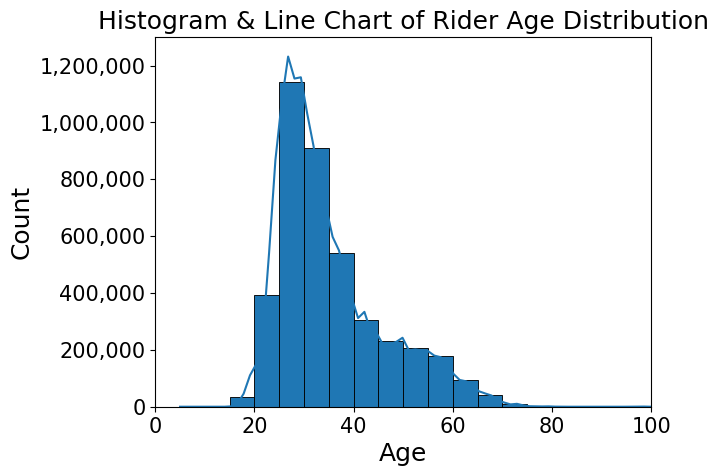

In [43]:
# create new column for age
df['rider_age'] = 2019 - df['birthyear']


z = sns.histplot(data = df, x="rider_age", alpha = 1.0, binwidth = 5, kde = True)
z.set(xlim=(0,100), ylim=(0,1300000) )

plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter("{x:,.0f}"))
# plt.ticklabel_format(style='plain', axis='y')
plt.title("Histogram & Line Chart of Rider Age Distribution", fontsize=18)
plt.xlabel("Age", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

In [44]:
df.columns

Index(['start_time', 'end_time', 'tripduration', 'from_station_id',
       'from_station_name', 'to_station_id', 'to_station_name', 'usertype',
       'gender', 'birthyear', 'origin_latitude', 'origin_longitude',
       'origin_dpcapacity', 'destination_latitude', 'destination_longitude',
       'destination_dpcapacity', 'solarRadiationHigh', 'uvHigh', 'winddirAvg',
       'humidityHigh', 'humidityLow', 'humidityAvg', 'qcStatus', 'tempHigh',
       'tempLow', 'tempAvg', 'windspeedHigh', 'windspeedLow', 'windspeedAvg',
       'windgustHigh', 'windgustLow', 'windgustAvg', 'dewptHigh', 'dewptLow',
       'dewptAvg', 'windchillHigh', 'windchillLow', 'windchillAvg',
       'heatindexHigh', 'heatindexLow', 'heatindexAvg', 'pressureMax',
       'pressureMin', 'pressureTrend', 'precipRate', 'precipTotal',
       'day_of_week', 'is_weekday', 'hour_of_day', 'y_m_d', 'season',
       'rider_age', 'Holiday_Name', 'Year_Date', 'Month_Date', 'Day_Date',
       'is_holiday', 'break_types', 'is_short'

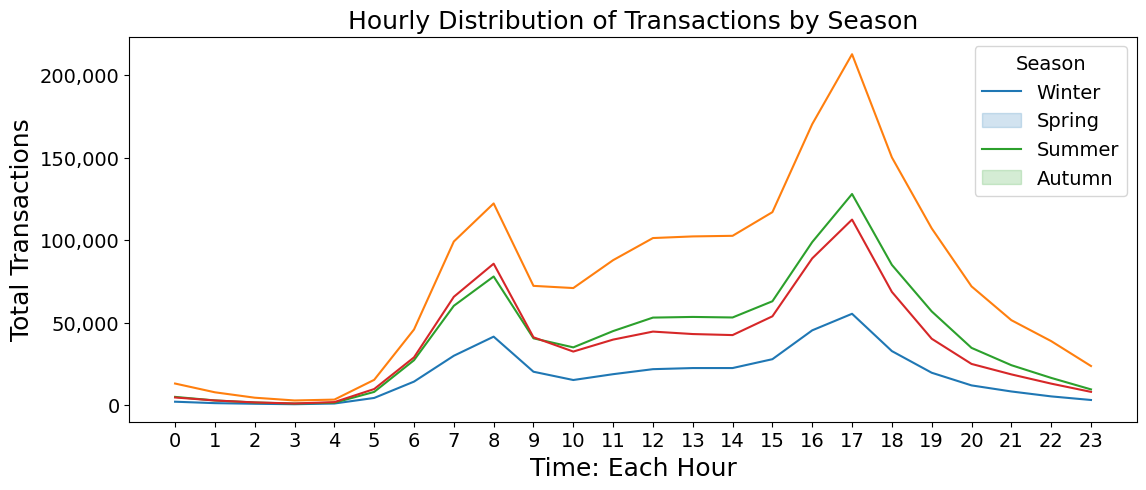

In [45]:
SeasonHour_count = df.groupby(["hour_of_day", "season"],as_index=False)['gender'].count() \
                                            .rename(columns={'gender': 'total'}) \
                                            .sort_values('hour_of_day', ascending=False) 
#print(SeasonHour_count.head())
palette_tab10 = sns.color_palette("tab10", 10)
#Plot 
plt.figure(figsize=(13,5))
sns.lineplot(data=SeasonHour_count, x='hour_of_day', y='total', hue='season', palette=[palette_tab10[0], palette_tab10[2], palette_tab10[1], palette_tab10[3]])\
.set_xticks(range(0,24))

plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter("{x:,.0f}"))
plt.xlabel('Time: Each Hour', fontsize=18)
plt.ylabel('Total Transactions', fontsize=18)
plt.title("Hourly Distribution of Transactions by Season", fontsize=18)
plt.legend(["Winter", "Spring", "Summer", "Autumn"], title="Season", title_fontsize = 14, fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

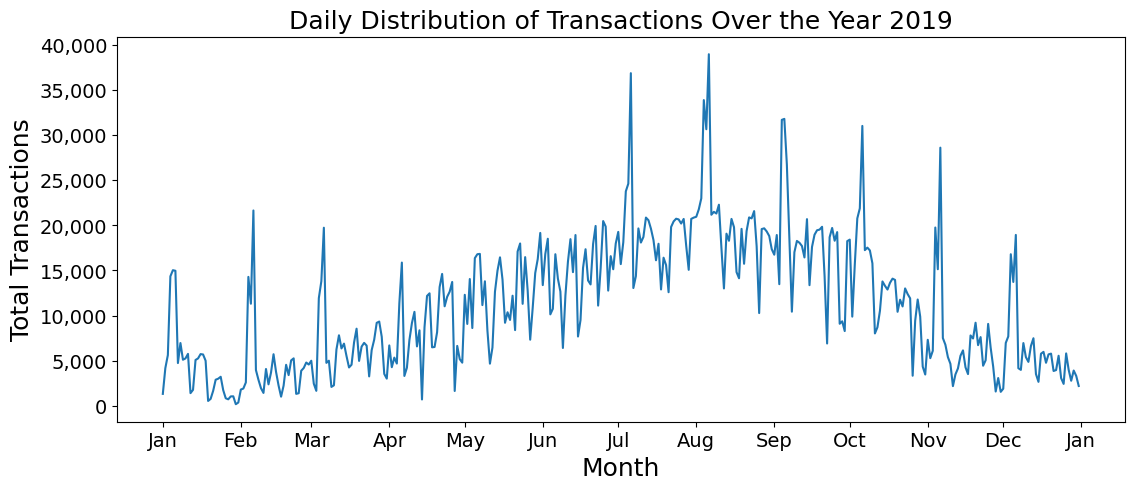

In [46]:
import matplotlib.dates as mdates

df["y_m_d"] = pd.to_datetime(df["y_m_d"])
Daily_count = df.groupby(['y_m_d'],as_index=False)['gender'].count().rename(columns={'gender': 'total'}) 
#len(Daily_count['y_m_d'].unique())
#print(Daily_count)

# Set the locator
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b')

#Plot 
plt.figure(figsize=(13,5))

sns.lineplot(data=Daily_count, x='y_m_d', y='total')
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(fmt)
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter("{x:,.0f}"))
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)  
plt.xlabel('Month', fontsize=18)
plt.ylabel('Total Transactions', fontsize=18)
plt.title("Daily Distribution of Transactions Over the Year 2019", fontsize=18)


plt.show()

In [47]:
aggregated_daily = pd.read_csv("aggregated_daily_data.csv")

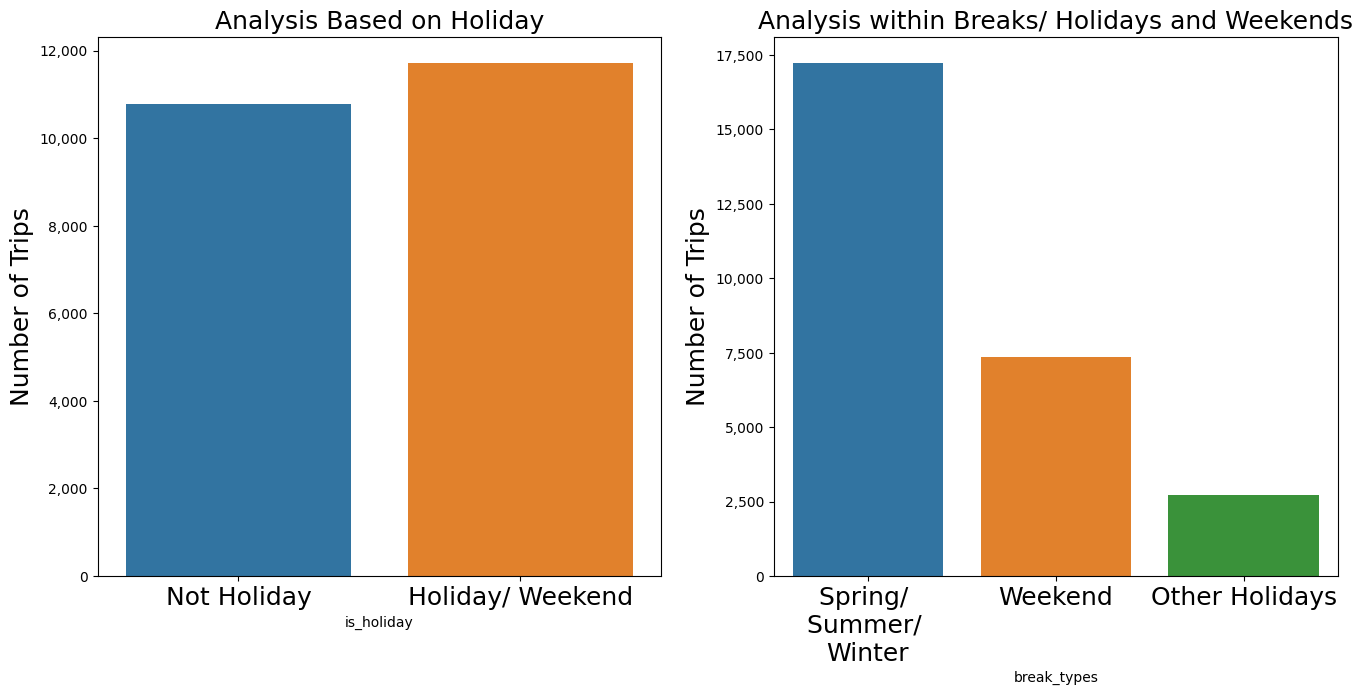

In [48]:
df["y_m_d"] = pd.to_datetime(df["y_m_d"])
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,7))

# first
hol_grp = aggregated_daily.groupby("is_holiday").agg({"Demand": "mean"}).reset_index().rename({"Demand": "Average Demand"}, axis=1)
# hol_grp

sns.barplot(data=hol_grp, x="is_holiday", y="Average Demand", ax=ax[0])
plt.ticklabel_format(style='plain', axis='y')

ax[0].set_title("Analysis Based on Holiday", fontsize=18)
ax[0].set_xticklabels(('Not Holiday', 'Holiday/ Weekend'), fontsize=18)
ax[0].set_ylabel('Number of Trips', fontsize=18)

sns.set(font_scale=5)

ax[0].yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter("{x:,.0f}"))
sns.reset_defaults()

# second 
break_data = aggregated_daily[aggregated_daily['break_types'] != 0]

br_grp = break_data.groupby("break_types").agg({"Demand": "mean"}).reset_index().rename({"Demand": "Average Demand"}, axis=1)
# br_grp

sns.barplot(data=br_grp, x='break_types', y="Average Demand", ax=ax[1])

ax[1].set_title("Analysis within Breaks/ Holidays and Weekends", fontsize=18)
ax[1].set_xticklabels(('Spring/ \nSummer/ \nWinter', 'Weekend', 'Other Holidays'), fontsize=18)
ax[1].set_ylabel('Number of Trips', fontsize=18)
plt.ticklabel_format(style='plain', axis='y')
ax[1].yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter("{x:,.0f}"))

plt.show()
sns.set()
sns.reset_defaults()


In [49]:
df['tripduration_min'] = df['tripduration'].div(60).round(2)


sunburst_data = df.groupby(['gender','Holiday_Name']
                                              , as_index=False).agg({'tripduration_min': 'mean'})

fig_tripduration = px.sunburst(sunburst_data, path = ['gender','Holiday_Name'], 
                        values = 'tripduration_min',
                        color = 'tripduration_min',
                        color_continuous_scale = 'blues',
                        maxdepth = -1)

fig_tripduration.update_layout(margin = dict(t = 10, b = 10, r = 10, l = 10),
                                showlegend = False,
                                plot_bgcolor = 'black',
                                )
                  
fig_tripduration.show()

In [50]:
# show where are all the stations 
stations1 = df[["from_station_id", "origin_latitude", "origin_longitude"]]
stations2 = df[["to_station_id", "destination_latitude", "destination_longitude"]]

stations1 = stations1.rename(columns={'from_station_id': 'stationid', 'origin_latitude': 'lat', 'origin_longitude': 'lon'})
stations2 = stations2.rename(columns={'to_station_id': 'stationid', 'destination_latitude': 'lat', 'destination_longitude': 'lon'})

station = stations1.append(stations2)
station = station.drop_duplicates()
station = station.dropna(inplace=False)
station = station.reset_index(drop = True)

#Define coordinates of where we want to center our map
boulder_coords = [41.881832, -87.623177]

#Create the map
my_map = folium.Map(location = boulder_coords, zoom_start = 11)

# Add the markers
for t in range(len(station)):
    coords = [station['lat'][t], station['lon'][t]]
    folium.CircleMarker(coords,radius=1, popup = station['stationid'][t]).add_to(my_map)
    
#Display the map
my_map

## Top 20 Stations

In [51]:
df["route"] = df["from_station_id"].astype(str) + "-" + df["to_station_id"].astype(str) 
 
routing = df[["route", "is_weekday", "hour_of_day",'origin_latitude','origin_longitude', 'destination_latitude','destination_longitude', 'from_station_name', 'to_station_name', 'from_station_id','to_station_id']] 
routing = routing.groupby(by=["route", "is_weekday", 'origin_latitude','origin_longitude', 'destination_latitude','destination_longitude', 'from_station_name', 'to_station_name', 'from_station_id','to_station_id']).count() 
routing = routing.reset_index() 
routing = routing.rename(columns={'hour_of_day': 'count'}) 
 
 
 
boulder_coords = [41.881832, -87.623177] 
# #Create the map 
weekday_routemap = folium.Map(location = boulder_coords, zoom_start = 12.5)  
weekend_routemap = folium.Map(location = boulder_coords, zoom_start = 12.5)     
 
for t in range(2): 
    dd = routing[routing["is_weekday"] == t] 
    dd = dd.sort_values(by=['count'], ascending=False) 
    dd = dd.head(40) 
    dd = dd.reset_index(drop=True) 
    lines = [] 
    for h in range(40): 
        origin = (dd["origin_latitude"][h], dd["origin_longitude"][h]) 
        dest = (dd["destination_latitude"][h], dd["destination_longitude"][h]) 
        tgt = [origin, dest] 
        lines.append(tgt) 
         
    dd["lines"] = lines 
    if t == 1: 
        weekday = dd 
        a = weekday[["origin_latitude", "origin_longitude", "from_station_name", 'from_station_id', "count"]] 
        b = weekday[["destination_latitude", "destination_longitude", "to_station_name",'to_station_id', "count"]] 
        a = a.rename(columns={"origin_latitude": "lat", 'origin_longitude': "lon",'from_station_name': "station_name", 'from_station_id': "stationid" }) 
        b = b.rename(columns={"destination_latitude": "lat", 'destination_longitude': "lon","to_station_name": "station_name", 'to_station_id': "stationid"}) 
 
        c = a.append(b) 
        c = c.groupby(by=["lat", "lon", "station_name", "stationid"]).sum() 
        c = c.reset_index() 
        c = c.sort_values(by=['count'], ascending=False) 
        c = c.head(30) 
        c = c.reset_index(drop = True) 
        weekday_top20 = c
#         print("weekday")
#         display(c)
         
        for q in range(len(c)): 
            points = [c['lat'][q], c['lon'][q]] 
            folium.Marker(points, popup=c['station_name'][q]).add_to(weekday_routemap) 
         
        for e in range(len(weekday)): 
            folium.PolyLine(weekday["lines"][e], color= "black", weight=0.7, opacity=0.9).add_to(weekday_routemap) 
 
         
    elif t == 0: 
        weekend = dd 
        a = weekend[["origin_latitude", "origin_longitude", "from_station_name", 'from_station_id', "count"]] 
        b = weekend[["destination_latitude", "destination_longitude", "to_station_name",'to_station_id', "count"]] 
        a = a.rename(columns={"origin_latitude": "lat", 'origin_longitude': "lon",'from_station_name': "station_name", 'from_station_id': "stationid" }) 
        b = b.rename(columns={"destination_latitude": "lat", 'destination_longitude': "lon","to_station_name": "station_name", 'to_station_id': "stationid"}) 
 
 
        c = a.append(b) 
        c = c.groupby(by=["lat", "lon", "station_name","stationid"]).sum() 
        c = c.reset_index() 
        c = c.sort_values(by=['count'], ascending=False) 
        c = c.head(30) 
        c = c.reset_index(drop = True) 
        weekend_top20 = c 
#         print("weekend")
#         display(c)
 
 
         
         
        for q in range(len(c)): 
            points = [c['lat'][q], c['lon'][q]] 
            folium.Marker(points, popup=c['station_name'][q]).add_to(weekend_routemap) 
         
        for e in range(len(weekend)): 
            folium.PolyLine(weekend["lines"][e], color= "black", weight=0.7, opacity=0.9).add_to(weekend_routemap) 

t20 = pd.merge(weekday_top20, weekend_top20, how='left', left_on=["lat","lon", "station_name", "stationid"], right_on = ["lat","lon", "station_name", "stationid"])
t20
t20.loc[t20["count_y"].isnull(), "count_y"] = 0
t20["Count"] = t20["count_x"] + t20["count_y"]
t20["Count"] = t20["Count"].apply(int)
t20 = t20.sort_values(by=["Count"], ascending=False)

t20 = t20.head(20)
top_20_station = t20["station_name"].tolist()

df2 = df[df["from_station_name"].isin(top_20_station)]
df2 = df2[df2["to_station_name"].isin(top_20_station)]

df2.reset_index(drop=True, inplace=True)
df2
daily = df2.groupby(["y_m_d"]).agg({"tripduration": "mean",
                                                                   "solarRadiationHigh": "max",
                                                                   "uvHigh": "max",
                                                                   "winddirAvg": "mean",
                                                                   "humidityHigh": "max",
                                                                   "humidityLow": "min",
                                                                   "humidityAvg": "mean",
                                                                   "tempHigh": "max",
                                                                   "tempLow": "min",
                                                                   "tempAvg": "mean",
                                                                   "windspeedHigh": "max",
                                                                   "windspeedLow": "min",
                                                                   "windspeedAvg": "mean",
                                                                   "windgustHigh": "max",
                                                                   "windgustLow": "min",
                                                                   "windgustAvg": "mean",
                                                                   "dewptHigh": "max",
                                                                   "dewptLow": "min",
                                                                   "dewptAvg": "mean",
                                                                   "windchillHigh": "max",
                                                                   "windchillLow": "min",
                                                                   "windchillAvg": "mean",
                                                                   "heatindexHigh": "max",
                                                                   "heatindexLow": "min",
                                                                   "heatindexAvg": "mean",
                                                                   "pressureMax": "max",
                                                                   "pressureMin": "min",
                                                                   "pressureTrend": "mean",
                                                                   "precipRate": "mean",
                                                                   "precipTotal": "sum",
                                                                  "day_of_week": "mean",
                                                                  "is_weekday": "mean",
                                                                  "season": "mean",
                                                                  "is_holiday": "mean",
                                                                  "break_types": "mean",
                                                                  "Month_Date": "mean",

                                                                   "start_time": "count" # need rename later
                                   
                                   
    
})
daily = daily.reset_index()
daily
daily2 = daily.rename({"start_time": "Demand"}, axis=1)

In [52]:
weekday_routemap

In [53]:
weekend_routemap

In [54]:
df = pd.read_csv("top_20_stations.csv")

In [55]:
df

start_time             end_time  tripduration  \
0       2019-01-01 00:25:28  2019-01-01 00:27:10         102.0   
1       2019-01-01 02:03:24  2019-01-01 02:07:24         240.0   
2       2019-01-01 06:52:55  2019-01-01 07:14:00        1265.0   
3       2019-01-01 06:53:01  2019-01-01 07:14:16        1275.0   
4       2019-01-01 07:08:47  2019-01-01 07:16:53         486.0   
...                     ...                  ...           ...   
221465  2019-12-31 23:49:38  2020-01-01 00:15:19        1540.0   
221466  2019-12-31 23:49:43  2020-01-01 00:21:51        1927.0   
221467  2019-12-31 23:49:51  2020-01-01 00:22:08        1936.0   
221468  2019-12-31 23:49:53  2020-01-01 00:22:30        1956.0   
221469  2019-12-31 23:56:34  2020-01-01 00:22:08        1533.0   

        from_station_id          from_station_name  to_station_id  \
0                    35    streeter dr & grand ave             35   
1                    44     state st & randolph st            195   
2                   174      canal st & madison st              3   
3                   174      canal st & madison st              3   
4                    76  lake shore dr & monroe st             90   
...                 ...                        ...            ...   
221465               90            millennium park             76   
221466               90            millennium park             76   
221467               90            millennium park             76   
221468               90            millennium park             76   
221469               90            millennium park             90   

                  to_station_name    usertype  gender  birthyear  \
0         streeter dr & grand ave  Subscriber    Male     1985.0   
1       columbus dr & randolph st  Subscriber    Male     1993.0   
2                  shedd aquarium  Subscriber  Female     1982.0   
3                  shedd aquarium  Subscriber  Female     1986.0   
4                 millennium park  Subscriber    Male     1965.0   
...                           ...         ...     ...        ...   
221465  lake shore dr & monroe st    Customer  Female     1978.0   
221466  lake shore dr & monroe st    Customer    Male     1996.0   
221467  lake shore dr & monroe st    Customer    Male     1987.0   
221468  lake shore dr & monroe st    Customer    Male     1980.0   
221469            millennium park  Subscriber    Male     1992.0   

        origin_latitude  origin_longitude  origin_dpcapacity  \
0             41.892278        -87.612043               47.0   
1             41.884730        -87.627734               27.0   
2             41.882091        -87.639833               35.0   
3             41.882091        -87.639833               35.0   
4             41.880958        -87.616743               39.0   
...                 ...               ...                ...   
221465        41.881032        -87.624084               47.0   
221466        41.881032        -87.624084               47.0   
221467        41.881032        -87.624084               47.0   
221468        41.881032        -87.624084               47.0   
221469        41.881032        -87.624084               47.0   

        destination_latitude  destination_longitude  destination_dpcapacity  \
0                  41.892278             -87.612043                    47.0   
1                  41.884728             -87.619521                    47.0   
2                  41.867226             -87.615355                    55.0   
3                  41.867226             -87.615355                    55.0   
4                  41.881032             -87.624084                    47.0   
...                      ...                    ...                     ...   
221465             41.880958             -87.616743                    39.0   
221466             41.880958             -87.616743                    39.0   
221467             41.880958             -87.616743                    39.0   
221468             

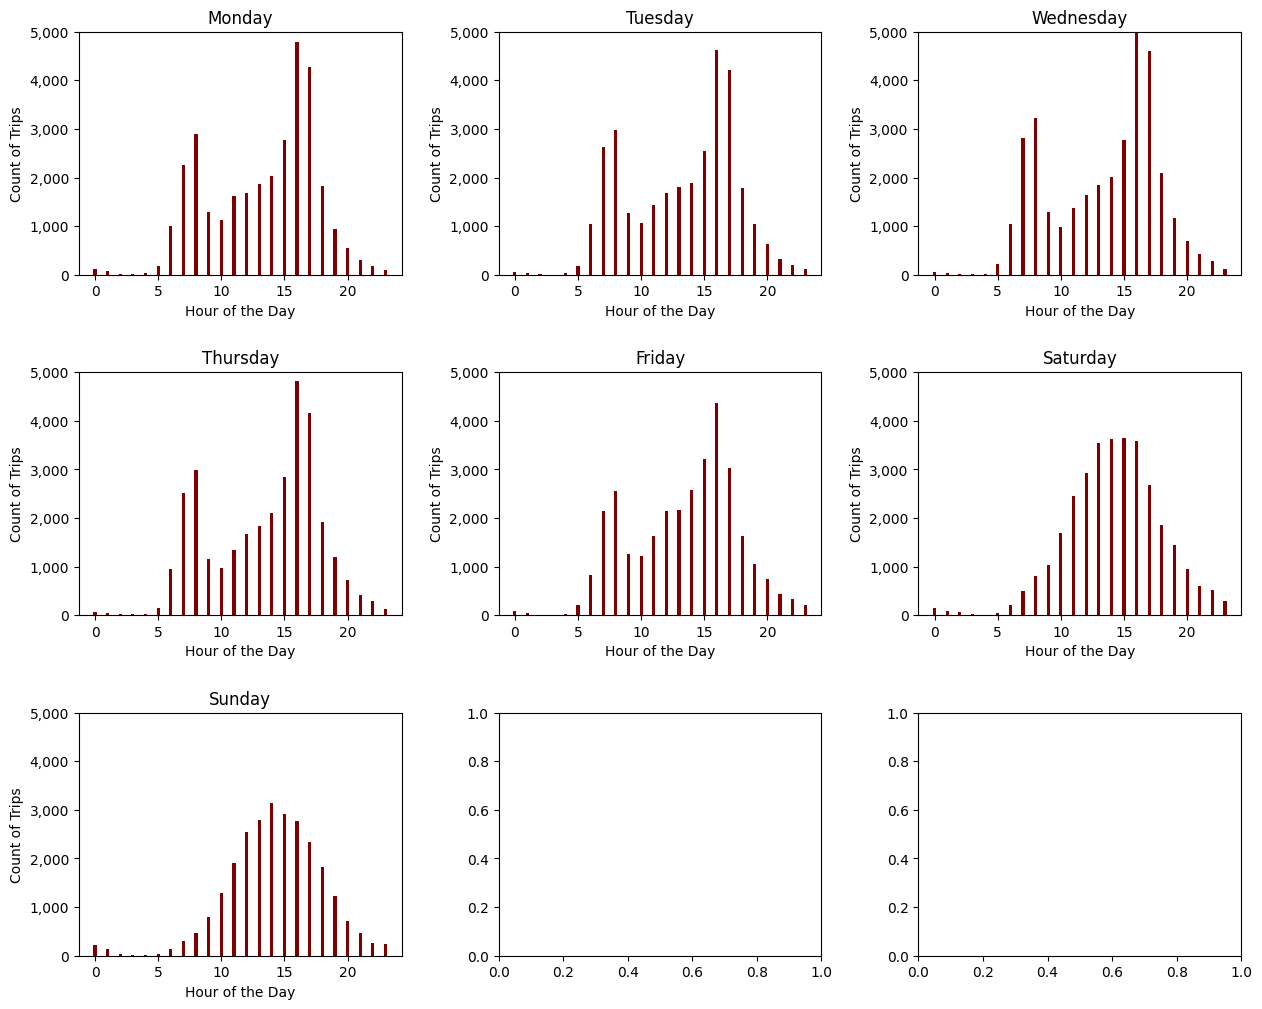

In [56]:
data = df[["tripduration",'day_of_week', 'hour_of_day']]

table = data.groupby(by=["day_of_week","hour_of_day"]).count()
table = table.reset_index()
# table["day_of_week"] = table["day_of_week"].replace([0, 1, 2, 3,4,5,6], ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
table = table.rename(columns={'tripduration': 'count'})
table

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
theplots = [[0,0],[0,1],[0,2], [1,0], [1,1], [1,2], [2,0]]

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
fig.subplots_adjust(hspace=0.4, wspace=0.3)
# fig.set_xlabel('Hour of the Day')
# fig.set_ylabel('Count of Trips')

for i in range(7):
    dd = table[table["day_of_week"] == i]
    x = dd["hour_of_day"]
    y = dd["count"]
    plotnum1 = theplots[i][0]
    plotnum2 = theplots[i][1]
    axs[plotnum1, plotnum2].bar(x, y, color ='maroon',width = 0.25)
    axs[plotnum1, plotnum2].title.set_text(days[i])
    axs[plotnum1, plotnum2].set_ylim(bottom=0, top=5000)
    axs[plotnum1, plotnum2].set_xlabel('Hour of the Day')
    axs[plotnum1, plotnum2].set_ylabel('Count of Trips')
    axs[plotnum1, plotnum2].yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter("{x:,.0f}"))
    

plt.show()

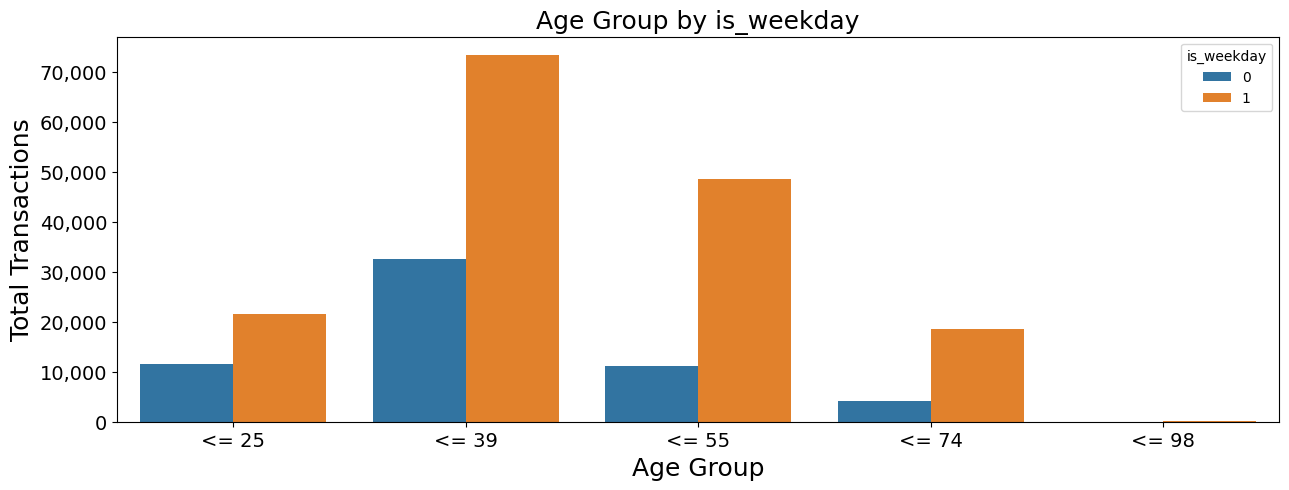

In [57]:
df['Age'] = 2019 - df['birthyear']
def convert_age_category(row):
    if row['Age'] <= 25:
        return '<= 25'
    elif row['Age'] <= 39:
        return '<= 39'
    elif row['Age'] <= 55:
        return '<= 55'
    elif row['Age'] <= 74:
        return '<= 74'
    elif row['Age'] <= 98:
        return '<= 98'
    else:
        return 'unknown'

# Apply function
df['age_group'] = df.apply(convert_age_category, axis=1)

import seaborn as sns
agedemo = df.groupby(['is_weekday','age_group'],as_index=False)['gender'].count()
agedemo = agedemo.rename(columns={'gender': 'total'}) 
 
plt.figure(figsize=(15,5))
sns.barplot(data=agedemo, x='age_group', y='total', hue='is_weekday')
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter("{x:,.0f}"))
plt.xlabel('Age Group', fontsize=18)
plt.ylabel('Total Transactions', fontsize=18)
plt.title("Age Group by is_weekday", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.legend(["Weekend",'Weekday'])
plt.show()


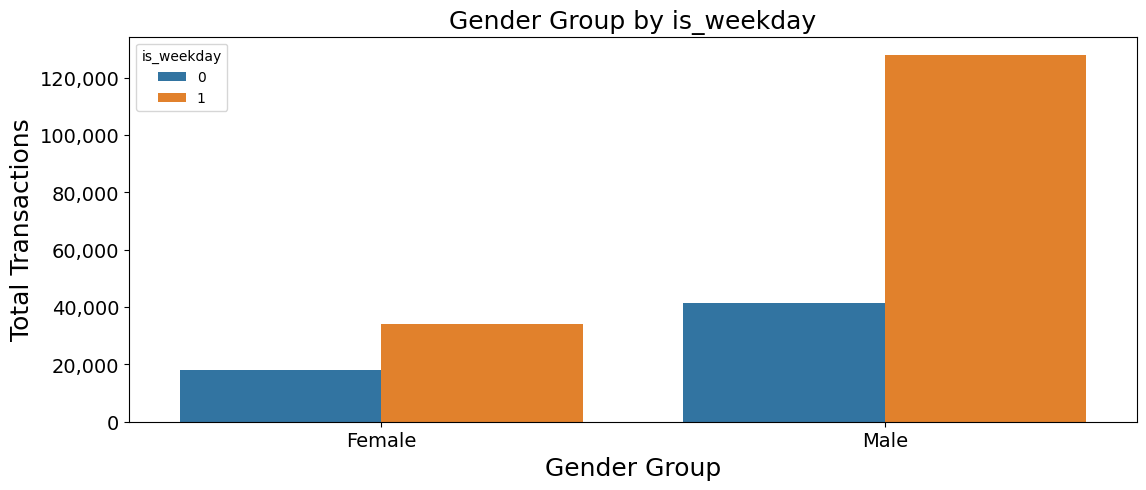

In [58]:
agedemo = df.groupby(['is_weekday','gender'],as_index=False)['hour_of_day'].count()
agedemo = agedemo.rename(columns={'hour_of_day': 'total'}) 

 
plt.figure(figsize=(13,5))
sns.barplot(data=agedemo, x='gender', y='total', hue='is_weekday')
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter("{x:,.0f}"))
plt.xlabel('Gender Group', fontsize=18)
plt.ylabel('Total Transactions', fontsize=18)
plt.title("Gender Group by is_weekday", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.legend(["Weekend",'Weekday'])
plt.show()

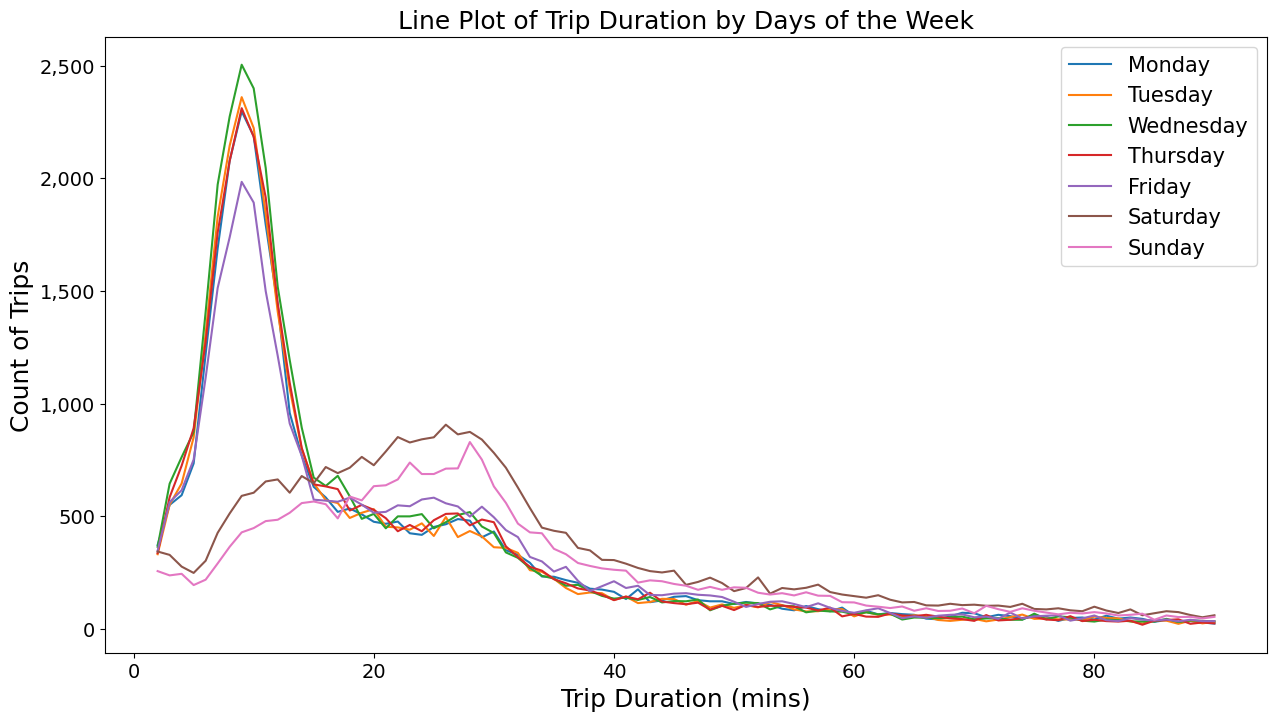

In [59]:
data = df[["tripduration",'day_of_week', 'hour_of_day']]
data["tripduration"] = data["tripduration"]/60
data = data[data["tripduration"] <= 90]
data['tripduration'] = data['tripduration'].apply(np.ceil)


table = data.groupby(by=["day_of_week", "tripduration"]).count()
table = table.reset_index()
table = table.rename(columns={'hour_of_day': 'count'})


f = plt.figure()
f.set_figwidth(15)
f.set_figheight(8)


for u in range(7):
    dd = table[table["day_of_week"] == u]
    x = dd["tripduration"]
    y = dd["count"]
    plt.plot(x, y, label = days[u])
    
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter("{x:,.0f}"))
plt.title("Line Plot of Trip Duration by Days of the Week", fontsize=18)
plt.xlabel("Trip Duration (mins)", fontsize=18)
plt.ylabel("Count of Trips", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=15)
plt.show()



In [60]:
# show where are the selected 20 stations 
stations1 = df[["from_station_name", "origin_latitude", "origin_longitude"]]
stations2 = df[["to_station_name", "destination_latitude", "destination_longitude"]]

stations1 = stations1.rename(columns={'from_station_name': 'station name', 'origin_latitude': 'lat', 'origin_longitude': 'lon'})
stations2 = stations2.rename(columns={'to_station_name': 'station name', 'destination_latitude': 'lat', 'destination_longitude': 'lon'})

station = stations1.append(stations2)
station = station.drop_duplicates()
station = station.dropna(inplace=False)
station = station.reset_index(drop = True)


#Define coordinates of where we want to center our map
boulder_coords = [41.881832, -87.623177]

#Create the map
my_map = folium.Map(location = boulder_coords, zoom_start = 11)

# Add the markers
for t in range(len(station)):
    coords = [station['lat'][t], station['lon'][t]]
    folium.Marker(coords, popup = station['station name'][t]).add_to(my_map)
    
#Display the map
my_map